<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# 2.0 Transformer Encoder

In this notebook, you'll look deeper at the encoder mechanics, positional encoding, and how self-attention works.

**[2.1 Overview](#2.1-Overview)<br>**
**[2.2 Embedding](#2.2-Embedding)<br>**
**[2.3 Positional Encoding](#2.3-Positional-Encoding)<br>**
**[2.4 Self-Attention](#2.4-Self-Attention)<br>**
&nbsp;&nbsp;&nbsp;&nbsp;[2.4.1 Self-Attention Matrix Calculation](#2.4.1-Self-Attention-Matrix-Calculation)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.4.2 Visualization of Attention](#2.4.2-Visualization-of-Attention)<br>
**[2.5 Multi-Head Attention](#2.5-Multi-Head-Attention)<br>**

# 2.1 Overview
In the Transformer paper, both encoder and decoder are composed of $\mathbf{N = 6}$ identical layers each, for a total of 12 layers. Each of the six encoder layers has two sub-layers: The first is a multi-head self-attention mechanism; the second is a simple, position-wise fully connected feed-forward network.  

The encoder’s purpose is to encode a source sentence into hidden state vectors; the decoder uses the last representation of the state vectors to predict characters in the target language. 

Let's see what is happening inside an encode block. 

<center> <img src="images/encoder1.png" width="500"></center>

<center> Figure 4. Encoder Block illustration. </center>

The encoder code is provided below. A number of `TransformerEncoderLayers` (default 6) are added to `self.layers`, which will be called when we forward pass through the model.

When `TransformerEncoder.forward()` is called, the input source tokens (`src_tokens`) are embedded (using `embed_tokens`) and then added to the positional encodings (see the description later). After dropout and some tensor manipulation, our embedded tokens `x` are passed through each of the six `TranformerEncoderLayers`, in the loop that starts `for layer in self.layers`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import seaborn as sns

from encoder_demos.demo_fairseq.models.fairseq_model import BaseFairseqModel, FairseqDecoder, FairseqEncoder
from encoder_demos.demo_fairseq.models.fairseq_incremental_decoder import FairseqIncrementalDecoder

In [3]:
import torch.nn as nn
class TransformerEncoder(nn.Module):
    """Transformer encoder."""

    def __init__(self, args, embed_tokens, left_pad=True):
        super().__init__()
        self.dropout = args.dropout
        self.fuse_dropout_add = args.fuse_dropout_add
        self.fuse_relu_dropout = args.fuse_relu_dropout

        embed_dim = embed_tokens.embedding_dim
        self.padding_idx = embed_tokens.padding_idx
        self.max_source_positions = args.max_source_positions

        self.embed_tokens = embed_tokens
        self.embed_scale = math.sqrt(embed_dim)
        self.embed_positions = PositionalEmbedding(
            args.max_source_positions, embed_dim, self.padding_idx,
            left_pad=left_pad,
            learned=args.encoder_learned_pos,
        ) if not args.no_token_positional_embeddings else None

        self.layers = nn.ModuleList([])
        self.layers.extend([
            TransformerEncoderLayer(args)
            for i in range(args.encoder_layers)
        ])

        self.normalize = args.encoder_normalize_before
        if self.normalize:
            self.layer_norm = FusedLayerNorm(embed_dim) if args.fuse_layer_norm else nn.LayerNorm(embed_dim)

    def forward(self, src_tokens, src_lengths):
        # embed tokens and positions
        x = self.embed_scale * self.embed_tokens(src_tokens)
        if self.embed_positions is not None:
            x += self.embed_positions(src_tokens)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # B x T x C -> T x B x C
        # The tensor needs to copy transposed because
        # fused dropout is not capable of handing strided data
        if self.fuse_dropout_add :
            x = x.transpose(0, 1).contiguous()
        else :
            x = x.transpose(0, 1)

        # compute padding mask
        encoder_padding_mask = src_tokens.eq(self.padding_idx)
        if not encoder_padding_mask.any():
            _encoder_padding_mask = None
        else:
            _encoder_padding_mask = encoder_padding_mask

        # encoder layers
        for layer in self.layers:
            x = layer(x, _encoder_padding_mask)

        if self.normalize:
            x = self.layer_norm(x)

        return x, encoder_padding_mask # x.shape == T x B x C, encoder_padding_mask.shape == B x T

Each `TransformerEncoderLayer` is a copy of the TransformerEncoderLayer class defined [here](https://github.com/NVIDIA/DeepLearningExamples/blob/8c3514071275b2805b29372f6dabe515d431416f/PyTorch/Translation/Transformer/fairseq/models/transformer.py#L420). The full implementation includes optional layer normalization (removed here for the sake of simplicity).

Looking at the `forward` method, the embedded tokens `x` are passed through the self attention mechanism (explained below). By default `self.fuse_dropout_add` is `True` and `self.fuse_relu_dropout` is `False`, so the results of the self attention pass through a linear layer `fc1`, then have dropout applied, then through the second linear layer `fc2`.

# 2.2 Embedding

In order to understand how an encoder block works, we need the concept of *embedding*. We begin by turning each input word into a vector using an embedding algorithm. Word embedding is really all about improving the ability of networks to learn from text data. In simple terms, word embeddings are vector representations of a particular word. For more detailed information on embedding algorithms please see [Word2Vec](https://arxiv.org/pdf/1310.4546.pdf), [GloVe](https://nlp.stanford.edu/projects/glove/), and [fastText](https://fasttext.cc/).

Note that the embedding only happens in the bottom-most encoder. In Figure 4, the two input words are represented vectors. These are the embedding vectors. The Transformer model uses $\mathbf{d_{model} = 512}$, however this lab, and the NVIDIA implementation, use the “transformer-big” model $\mathbf{d_{model} = 1024}$.


Run the cell below to tokenize some input text. Tokenization converts a sentence into a list of numbers, ending in a 2, the representation for "end of sentence (EOS)". The tokenized representation will be combined with the positional encoder, to create the embedded vector, which is the input to the self-attention layer shown in Figure 4.

In [4]:
import encoder_demos.tokenize as tok

input_text = "I am looking for a place to eat."
tokens = tok.demo(input_text)
print("\nInput text:        %s\nTokenized output: " % input_text, tokens[0].numpy())

| [en] dictionary: 33712 types
| [de] dictionary: 33712 types

Input text:        I am looking for a place to eat.
Tokenized output:  [  40  105 1804   19   14  358   12 9637    5    2]


Now change the input text and see how the tokenized output vector is altered.

In [5]:
# Translate an input sentence in English to German

import encoder_demos.functional_translation as ft
input_sentence = "I am looking for a place to eat."

e, g, h = ft.demo(input_sentence)
print("En:", e)
print("German:", g)
print('')
print("H:", h)
print('H is the hypothesis along with an average log-likelihood')

| [en] dictionary: 33712 types
| [de] dictionary: 33712 types
| loading model(s) from /data/checkpoints/JoC_Transformer_FP32_PyT_20190304.pt
| Sentences are being padded to multiples of: 1
generated batches in  0.00026988983154296875 s
En: I am looking for a place to eat.
German: Ich bin auf der Suche nach einem Ort zu ße.

H: -0.3850874900817871
H is the hypothesis along with an average log-likelihood


Hypothesis scores are output as log-probabilities, thus are negative. We can calculate the probability of this hypothesis as exp(H).

In [6]:
print('Probability of H = {}'.format(round(np.exp(h),4)))

Probability of H = 0.6804


# 2.3 Positional Encoding 

Language models need to make use of the sequential nature of words in a sentence. Since the Transformer model contains no recurrent or convolutional units, positional encodings (PEs) are used to account for the order of the words in the input sequence. The positional encodings have the same dimension, d<sub>model</sub>, as the embeddings, so that the two can be summed (see Figure 4). This allows the model to understand the position of each word in the input text.

In the paper, the authors use sine and cosine functions of different frequencies for positional encoding:


<img src="images/pe.png" width="400">
where <i>pos</i> is the position and <i>i</i> is the dimension with range [0, d<sub>model</sub>/2). Let's explain the formula above via an example:

Let's assume that  d<sub>model</sub> = 4. This means that word 𝑤 at input sequence position <i>pos</i> ∈ [0, 𝐿−1] is represented with a 4-dimensional embedding 𝑒<sub>𝑤</sub> vector. Setting <i>i</i> ∈ [0, 2), then, for even indices  of 4-dimensional embedding vector, we will use sin(pos/10000<i><sup>2i/d<sub>model</sub></sup></i>) function, whereas for odd indices, we will use cos(pos/10000<i><sup>2i/d<sub>model</sub></sup></i>). 

Let's call our embedding vector index <i>k</i>, where <i>k</i> ∈ [0, 2<i>i</i>). The first position in our input sentence is pos = 0, and first index of the embedding vector is <i>k</i>=0. Now, the first PE (positional encoding) for the first dimension, <i>k</i> = 0, of the embedding vector will be sin(0/10000<sup>0/4</sup>), and the second PE for the second dimension, k = 1, will be cos(0/10000<sup>0/4</sup>). For the third, k = 2, and fourth dimensions, k =3, the PEs will be sin(0/10000<sup>2/4</sup>) and cos(0/10000<sup>2/4</sup>), respectively. 

Now we can write down the positional encoding for the first word of the input sequence:

PE (pos =0) = [sin(0/10000<sup>0/4</sup>), cos(0/10000<sup>0/4</sup>), sin(0/10000<sup>2/4</sup>), cos(0/10000<sup>2/4</sup>)].

in simple form:

PE (pos =0) = [sin(0/10000<sup>0</sup>), cos(0/10000<sup>0</sup>), sin(0/100), cos(0/100)] = [0, 1, 0, 1].

The next step is to add this vector to the embedding vector, e<sub>𝑤</sub>, and obtain a new vector, e'<sub>𝑤</sub>:

e'<sub>𝑤</sub> = PE (pos =0) + e<sub>𝑤</sub>.

And we calculate e'<sub>𝑤</sub> for each word in the input sequence, at pos = 1, 2, … L - 1.

The [PositionalEncoding](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) module below lets us add the positional encoding to the embedding vector. In addition, dropout is also applied to the sums of the embeddings and the positional encodings, in both the Encoder and Decoder stacks. In the original paper, for the base model, a rate of $P_{drop}=0.1$. Note that this is just a hypothetical example using a matrix of zeros, where the embedding dim =20, to showcase the PE function.

In [7]:
from torch.autograd import Variable
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        print("dropout:", dropout)
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        
        print("d_model:", d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0.0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        print("pe:", pe[:,0:2])
    
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)


dropout: 0
d_model: 20
pe: tensor([[[0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00],
         [8.4147e-01, 5.4030e-01, 3.8767e-01, 9.2180e-01, 1.5783e-01, 9.8747e-01, 6.3054e-02, 9.9801e-01, 2.5116e-02, 9.9968e-01, 9.9998e-03, 9.9995e-01, 3.9811e-03, 9.9999e-01, 1.5849e-03, 1.0000e+00, 6.3096e-04, 1.0000e+00, 2.5119e-04, 1.0000e+00]]])


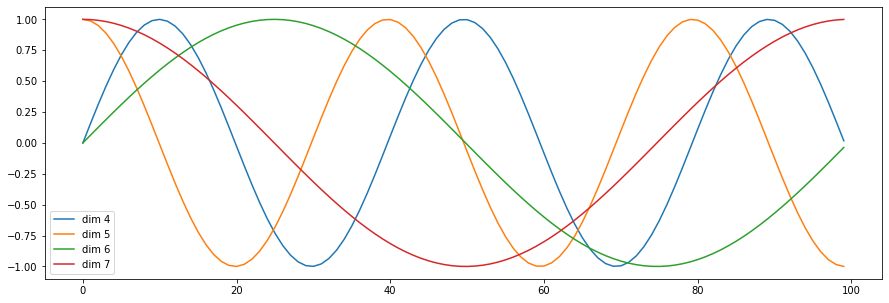

In [8]:
# visualization from harvardnlp/annotated-transformer GitHub (MIT license)
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
_ = plt.legend(["dim %d"%p for p in [4,5,6,7]])

Note the first position's positional encoding values:

[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00]

This is consistent with our PE calculations above.

# 2.4 Self-Attention

The first step in calculating self-attention is to create three vectors from each of the encoder’s input vectors (the embeddings). For each word, we create a Query vector, a Key vector, and a Value vector.

Now let's see how attention value is calculated. The attention function is defined as below:

<img src="images/attentionfunction.png" width="400">

Let's see how Q, K, V matrices are calculated. The Transformer views the encoded representation of the input as a set of key-value pairs, (K,V), both of dimension d<sub>k</sub>.

1. For each word, create a Query vector (q<sub>i</sub>), a Key vector (k<sub>i</sub>), and a Value vector (v<sub>i</sub>). These vectors are created by multiplying the embedding of the word by three matrices that are trained during the training process. 
2. Calculate the self-attention score for each word. The first word score is q<sub>1</sub>.k<sub>1</sub>, and for the second it is q<sub>1</sub>.k<sub>2</sub>.
3. Divide the scores by 8 (the square root of the dimension of the key vectors $\sqrt{𝑑_k}$ used in the paper).
4. Pass the result through a SoftMax operation.
5. Multiply each value vector by the SoftMax score: SoftMax x Value.
6. Sum up the weighted value vectors. This produces the output of the self-attention layer at this position (for the first word).

## 2.4.1 Self-Attention Matrix Calculation

Let's explore self-attention matrix calculation in details.

The figure below illustrates the matrix calculation of self-attention (compare this with the attention function above). First we pack our embeddings into a matrix <b>X</b>. Each row of the matrix <b>X</b> contains the embedding values of the each word in the input sequence, i.e., </b>X</b> = [<b>x<sub>1</sub></b>, <b>x<sub>2</sub></b>, ..., <b>x<sub>n</sub></b>], where each <b>x<i><sub>i</sub></i></b> is a vector of the embedding values representing the word <i>i</i>.

<center><img src="images/attention2.png" width="500"></center>
<center> Figure 5. Self-Attention Matrix Calculation formula. </center>


<b>Q</b> matrix is calculated by multiplying <b>X</b> with $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, <b>K</b> matrix is calculated by multiplying <b>X</b> with $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, and <b>V</b> matrix is calculated by multiplying <b>X</b> with $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$.

## 2.4.2 Visualization of Attention

Throughout this notebook we are exploring the functions that the NVIDIA PyTorch implementation of the Transformer network uses to translate English text into German. The cell below runs the entire network on one setence and prints the output.

To run this cell, we must have the following files:
* Pre-trained model checkpoints: /data/JoC_Transformer_FP32_PyT_20190304.pt
* En-De dataset


First we set up the modules that we need to visualize the self-attention.


In [9]:
import encoder_demos.self_attention as sa
def normalize(arr):
    out = np.zeros_like(arr)
    for rowno in range(arr.shape[0]):
        vals = arr[rowno, :]
        out[rowno, :] = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
    return out

Now we can plot the weights of one of the self-attention heads.

| [en] dictionary: 33712 types
| [de] dictionary: 33712 types
| loading model(s) from /data/checkpoints/JoC_Transformer_FP32_PyT_20190304.pt
| Sentences are being padded to multiples of: 1
generated batches in  0.00019097328186035156 s


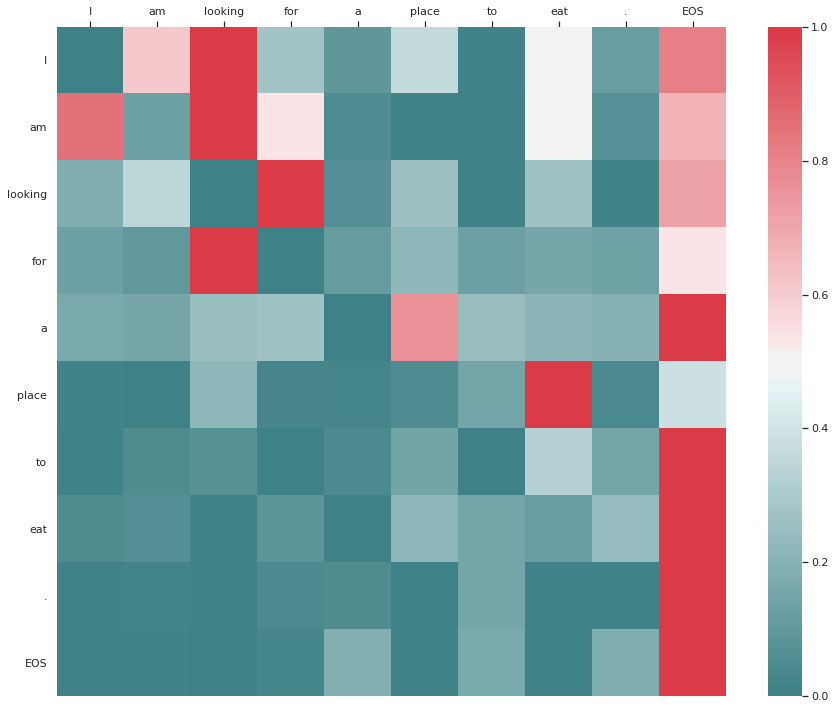

In [11]:
sentence = "I am looking for a place to eat."
#sentence = "This is a much more complex sentence and, as a result, is much longer."
attn, attn_weights = sa.demo(sentence, return_early='self_attn')
a_w =attn_weights[0,:, :].cpu().numpy()  #you can print the attention weights.

sentence += " EOS"
sentence = sentence.replace(".", " .").replace(",", " ,").split(" ")

a_w = normalize(a_w)

sns.set()
plt.figure(figsize=(15,15))
ax = sns.heatmap(a_w, vmin=0, vmax=1, cmap=sns.diverging_palette(200,10, n=200), xticklabels=sentence, square=True, yticklabels=sentence, cbar=True,cbar_kws={"shrink": .82})
ax.xaxis.set_ticks_position('top')
plt.yticks(rotation=0)
plt.show()


What happens here is that the Transformer compares each word (e.g., "place") to every other word in the sentence. The result of these comparisons is an attention score/weight for every other word in the sentence. These attention scores determine how much each of the other words should contribute to the next representation of a given word - “place” for example.

The strongest attention links are between some of the last words of the input sentence and the EOS (end of sentence) character. 

We find it helpful to visualize the strongest attention value for each word. To do this, run the cell above, but uncomment the line that normalizes the attention weights (`a_w = normalize(a_w)`).

Now you can see that for the first word "I", the most attention is given to the word "looking". When it comes to "eat", the EOS character takes the highest attention weight. The second highest attention score is given to "place".


# 2.5 Multi-Head Attention

Are two heads better than one?  How about eight?  A refinement of self-attention is called “multi-headed” attention, which allows the model to focus on different positions or sub-spaces. 

There are h = 8 parallel attention layers, or heads, in the Transformer architecture. This means that there are eight version of self-attention, all running simultaneously.

<center><img src="images/multiheadattention.png" width="300"></center>

<img src="images/multiheadattention1.png" width="600"> 
where $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$, and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.

Multi-head attention is essentially attention repeated several times in parallel. If we do the same self-attention calculation outlined above, h = 8 different times with different weight matrices, we end up with eight different <b>Z</b> matrices.

<center><img src="images/multihead.png"></center>
<center> Figure 6. Visual representation of multi-head attention mechanism.</center>

We see that a single attention head has a simple structure: it applies a unique linear transformation to its input queries, keys, and values, computes the attention score between each query and key, then uses it to weight the values and sum them up. The multi-head attention block just applies multiple blocks in parallel, concatenates their outputs, then applies one single linear transformation.



Note that a residual connection is employed around each of the two sub-layers, followed by layer normalization. In mathematical terms, that is, the output of each sub-layer
is LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. 

Steps to add residual connection, <i><b>X<sup>'</sup></b></i>, to the output of the multi-head attention layer, and then apply layer normalization are as follows:

1. Calculate positional embeddings for the input matrix.

<b>X′</b> = PE(<b>X</b>) +  <b>X</b> where <b>X′</b> ∈ℝ<sup>n<sub>input</sub>×d<sub>model</sub></sup>.

2. Perform multi-head attention layer, and produce the output matrix <b>Z<sup>E</sup><sub>1,1</sub></b>.

MultiHead(Q, K, V ) = Concat(head<sub>1</sub>, ..., head<sub>h</sub>)W<sup>O</sup>

3. Use residual connection and apply layer normalization to obtain <b>Z<sup>E</sup><sub>1,2</sub></b>  ∈ℝ<sup>n<sub>input</sub>×d<sub>model</sub></sup>.

<b>Z<sup>E</sup><sub>1,2</sub></b> = LayerNorm(<b>X′</b> + <b>Z<sup>E</sup><sub>1,1</sub></b>).

As a summary the left side of the Figure 1 would work like this:
     
Step1_out = Embedding512 + PositionEncoding512

Step2_out = layer_normalization(multihead_attention(Step1_out) + Step1_out)

Step3_out = layer_normalization(FFN(Step2_out) + Step2_out)

out_enc = Step3_out

<h2 style="color:green;">Congratulations!</h2>

You've learned that 
* Tranformer encoders have six (default) stacked encoder blocks
* An encoder block includes two parts: self-attention and feed forward
* Embedding algorithms create vector representations of words
* Positional encoding is required because there are no RNNs for sequencing
* Multi-head attention allows the model to focus in multiple sub-spaces

You'll examine the decoder next - move on to [3.0 Transformer Decoder](030_Decoder.ipynb).

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>